# Import packages I need and data

In [1]:
## import all the packages you need 
import psycopg2
import pandas as pd
from getpass import getpass
from sqlalchemy import create_engine
import seaborn as sns
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
# Enter database connection parameters
# Could also store and read these as environment variables,
# but best practice is to never include credentials directly
# in version control
hostname = "spinup-db001ec7.cluster-c9ukc6s0rmbg.us-east-1.rds.amazonaws.com"
username = "introml568"
password = "m7bxMRtyMqPbcxyRRGML8"
database_name = "synthea-omop"

In [3]:
# Connect using SQL Alchemy to support pandas mapping
alchemy_engine = create_engine(f"postgresql+psycopg2://{username}:{password}@{hostname}/{database_name}",  pool_recycle=3600)
db_connection = alchemy_engine.connect();

In [4]:
# Read in SQL tables through Pandas: Person and Visit 
omop_person = pd.read_sql("select * from omop.person", db_connection);
omop_visit = pd.read_sql("select * from omop.visit_occurrence", db_connection);

# Inclusion Cirteria

living patients

In [5]:
# p.DataFrame.merge objects with a database-style join
df = pd.merge(omop_person, omop_visit, on='person_id', how="inner")

In [6]:
omop_death = pd.read_sql("select * from omop.death", db_connection);
# merge two tables by person_id
df_inc = pd.merge(df, omop_death[['person_id', 'death_date']], on='person_id', how='left')

In [7]:
# living patients
df_inc = df_inc[df_inc.death_date.isnull()]
df_inc

,person_id,gender_concept_id,year_of_birth,month_of_birth,day_of_birth,birth_datetime,race_concept_id,ethnicity_concept_id,location_id,provider_id_x,...,provider_id_y,care_site_id_y,visit_source_value,visit_source_concept_id,admitted_from_concept_id,admitted_from_source_value,discharged_to_concept_id,discharged_to_source_value,preceding_visit_occurrence_id,death_date
49,2,8507,1979,6,30,1979-06-30,8527,38003564,None,None,...,5578,None,18ad60db-42be-f734-ab06-03a0cff48ad4,0,0,None,0,None,NaN,NaN
50,2,8507,1979,6,30,1979-06-30,8527,38003564,None,None,...,25,None,5c9f7838-c76c-747b-8a17-6af4c43b837a,0,0,None,0,None,82.0,NaN
51,2,8507,1979,6,30,1979-06-30,8527,38003564,None,None,...,5578,None,cc326e4a-4fcb-07cc-4aab-b454fb6f07a8,0,0,None,0,None,79.0,NaN
52,2,8507,1979,6,30,1979-06-30,8527,38003564,None,None,...,5578,None,bdf43d28-5b7d-3fc2-4e79-ca3db900ad82,0,0,None,0,None,76.0,NaN
53,2,8507,1979,6,30,1979-06-30,8527,38003564,None,None,...,25,None,b144cd30-30dd-2934-0da8-32fda989d657,0,0,None,0,None,80.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547139,11963,8532,1958,7,25,1958-07-25,8516,38003563,None,None,...,2,None,a40706bb-a818-3036-b7ac-6b191f8277ba,0,0,None,0,None,557249.0,NaN
547140,11963,8532,1958,7,25,1958-07-25,8516,38003563,None,None,...,2,None,50e33f96-c0af-c163-2afa-fd6dbf5111e9,0,0,None,0,None,557250.0,NaN
547141,11963,8532,1958,7,25,1958-07-25,8516,38003563,None,None,...,4872,None,eac804fb-ac13-2d90-4bce-75a897576c40,0,0,None,0,None,557251.0,NaN
547142,11963,8532,1958,7,25,1958-07-25,8516,38003563,None,None,...,2,None,097fa8ea-06d7-a8ad-06db-dfd3e5a6c9d0,0,0,None,0,None,557263.0,NaN


age 52-56

In [8]:
# define a function to find a person's visit age
def visit_age(x, y):
    difference_in_years = relativedelta(x, y).years
    return difference_in_years

# create a new variable named age at visit
df_inc['visit_age'] = df_inc.apply(lambda x: visit_age(x['visit_start_datetime'], x['birth_datetime']), axis=1)

In [9]:
df_inc = df_inc.loc[(df_inc.visit_age >= 52) & (df_inc.visit_age <= 56)]

visits 1-37

In [10]:
# do groupby clause to find the count of each person_id
visit_count = df_inc.groupby('person_id').agg({'visit_occurrence_id':'count'})
visit_count

,visit_occurrence_id
person_id,
3,1
5,8
7,14
9,5
11,2
...,...
11941,11
11943,12
11947,9


In [11]:
# find valid_id
valid_id = visit_count[(visit_count.visit_occurrence_id >= 1)&(visit_count.visit_occurrence_id <= 37)].index

In [12]:
# filter the person_id which visits 1-37 times
df_inc = df_inc.loc[df_inc.person_id.isin(list(valid_id))]

# Exclusion Criteria

The first criteria: Those seen with a sum of 3-17 visits with high systolic blood pressure(the cutoff 
point for high systolic bp is any value > 140) for any visit 

In [13]:
# read in a new table for concept
omop_concept = pd.read_sql("select * from omop.concept", db_connection);
# read in a new table for measurement
omop_meas = pd.read_sql("select * from omop.measurement", db_connection);

In [14]:
# merge two tables by measurement_concept_id
df_meas = pd.merge(omop_meas, omop_concept[['concept_id', 'concept_name']], left_on='measurement_concept_id', right_on='concept_id')

In [15]:
# find valid_id
valid_id_exc_1 = visit_count[(visit_count.visit_occurrence_id >= 3)&(visit_count.visit_occurrence_id <= 17)].index
# first filter
df_exc = df_inc[df_inc.person_id.isin(list(valid_id_exc_1))]

In [16]:
# second filter
valid_id_exc_2 = df_meas[df_meas.concept_name=='Systolic blood pressure'].person_id
df_exc = df_exc[df_exc.person_id.isin(list(valid_id_exc_2))]

In [17]:
# exclude the cooresponding person_id based on two filter conditions
df_criteria = df_inc[-df_inc.person_id.isin(df_exc.person_id)]

The second criteria: Visits which do not contain any associated measurements 

In [18]:
df = df_criteria[(df_criteria.person_id.isin(list(df_meas.person_id)))&(df_criteria.visit_start_datetime.isin(list(df_meas.measurement_datetime)))]

Developing My Cohort: 

In [19]:
# define a function to find a person's visit age
def visit_age(x, y):
    difference_in_years = relativedelta(x, y).years
    return difference_in_years

# create a new variable named age at visit
df['visit_age'] = df.apply(lambda x: visit_age(x['visit_start_datetime'], x['birth_datetime']), axis=1)

In [20]:
# calculated and added a new variable visit_length_hours
df['visit_length_hours'] = df.apply(lambda x: relativedelta(x['visit_end_date'], x['visit_start_datetime']).hours, axis=1)

In [21]:
# read in a new table for measurement
omop_condition = pd.read_sql("select * from omop.CONDITION_OCCURRENCE", db_connection);
# read in a new table for concept
omop_concept = pd.read_sql("select * from omop.concept", db_connection);

In [22]:
omop_condition.info() #condition_concept_id

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137727 entries, 0 to 137726
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   condition_occurrence_id        137727 non-null  int64         
 1   person_id                      137727 non-null  int64         
 2   condition_concept_id           137727 non-null  int64         
 3   condition_start_date           137727 non-null  object        
 4   condition_start_datetime       137727 non-null  datetime64[ns]
 5   condition_end_date             93193 non-null   object        
 6   condition_end_datetime         93193 non-null   datetime64[ns]
 7   condition_type_concept_id      137727 non-null  int64         
 8   condition_status_concept_id    137727 non-null  int64         
 9   stop_reason                    0 non-null       object        
 10  provider_id                    137727 non-null  int64         
 11  

In [23]:
omop_concept.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824709 entries, 0 to 5824708
Data columns (total 10 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   concept_id        int64 
 1   concept_name      object
 2   domain_id         object
 3   vocabulary_id     object
 4   concept_class_id  object
 5   standard_concept  object
 6   concept_code      object
 7   valid_start_date  object
 8   valid_end_date    object
 9   invalid_reason    object
dtypes: int64(1), object(9)
memory usage: 444.4+ MB


In [24]:
# merged two tables to a new DataFrame df_means on measurement_concept_id 
df_condition = pd.merge(omop_condition, omop_concept[['concept_id', 'concept_name']], left_on='condition_concept_id', right_on='concept_id')

In [25]:
# set date and personid to be the primary key
duplicate_row = df.duplicated(subset=['person_id','visit_start_datetime'],keep=False) 
df = df[-duplicate_row]

In [26]:
# set date and personid to be the primary key
duplicate_row = df_condition.duplicated(subset=['person_id','condition_start_datetime'],keep=False) 
df_condition = df_condition[-duplicate_row]

In [27]:
# merged two tables to a new DataFrame df_means on person_id and date
df = pd.merge(df, df_condition, left_on=['person_id','visit_start_datetime'], right_on=['person_id','condition_start_datetime'], how='left')

In [32]:
# filter
def hypertension(x):
    if 'hypertension' in str(x):
        return 'presence'
    else:
        return 'absence'

def diabetes(x):
    if 'Diabetes' in str(x):
        return 'presence'
    else:
        return 'absence'

In [33]:
df['hypertension'] = df.concept_name.apply(hypertension)
df['diabetes'] = df.concept_name.apply(diabetes)

In [34]:
df['measurement'] = df.concept_name

In [35]:
# keep the menaingful columns we want
col_keep = ['visit_start_datetime', 'person_id', 'gender_concept_id', 'visit_age',
            'race_source_value', 'ethnicity_source_value', 'visit_length_hours',
            'hypertension','diabetes','measurement']
df = df[col_keep]
df.head()

,visit_start_datetime,person_id,gender_concept_id,visit_age,race_source_value,ethnicity_source_value,visit_length_hours,hypertension,diabetes,measurement
0,2012-06-28,11,8507,56,white,nonhispanic,0,absence,absence,Hyperlipidemia
1,2012-07-19,11,8507,56,white,nonhispanic,0,absence,absence,NaN
2,2021-01-13,12,8507,52,white,nonhispanic,0,absence,absence,NaN
3,2022-01-19,12,8507,53,white,nonhispanic,0,absence,absence,NaN
4,2010-03-27,16,8532,54,white,nonhispanic,0,absence,absence,NaN


# Visualizing Descriptive Statistics of Our Data Set: 

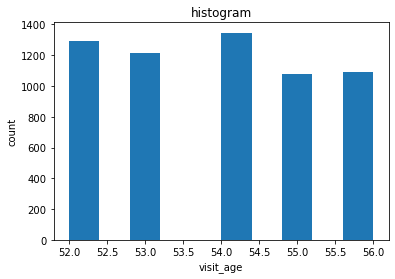

In [36]:
import matplotlib.pyplot as plt
plt.hist(df.visit_age)
plt.title("histogram")
plt.xlabel("visit_age")
plt.ylabel("count")
plt.show()

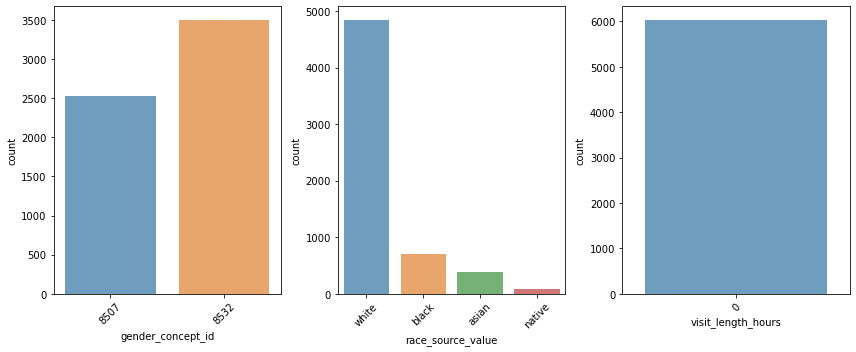

In [37]:
# select catgorical columns of interest
cat_col = ['gender_concept_id', 'race_source_value', 'visit_length_hours']
df_cat = df[cat_col]

# create figures and plots
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

for i, ax in enumerate(fig.axes):
    if i < len(df_cat.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=df_cat.columns[i], alpha=0.7, data=df_cat, ax=ax)

fig.tight_layout()

From the histogram of visit_age, we can find the age from 54-54.5 account for the most. The number of 8532 gender of patients is slightly higher than 8507 gender. Most of the SYNTHEA patients are white people.

In [38]:
df_temp = pd.merge(df, visit_count,on='person_id')

In [39]:
cat_col = ['visit_occurrence_id','gender_concept_id', 'measurement', 'race_source_value', 'ethnicity_source_value']
df_cat = df_temp[cat_col]

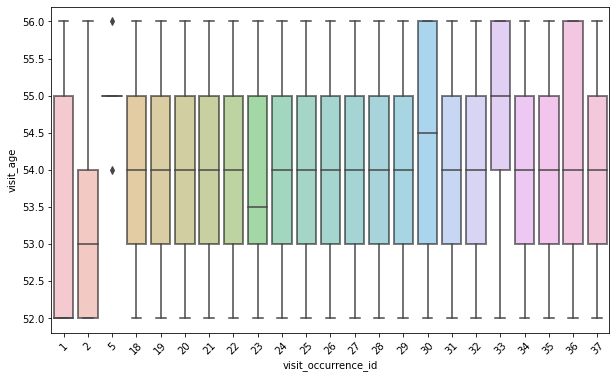

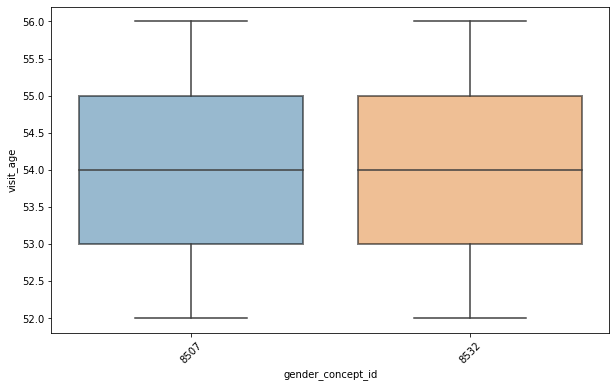

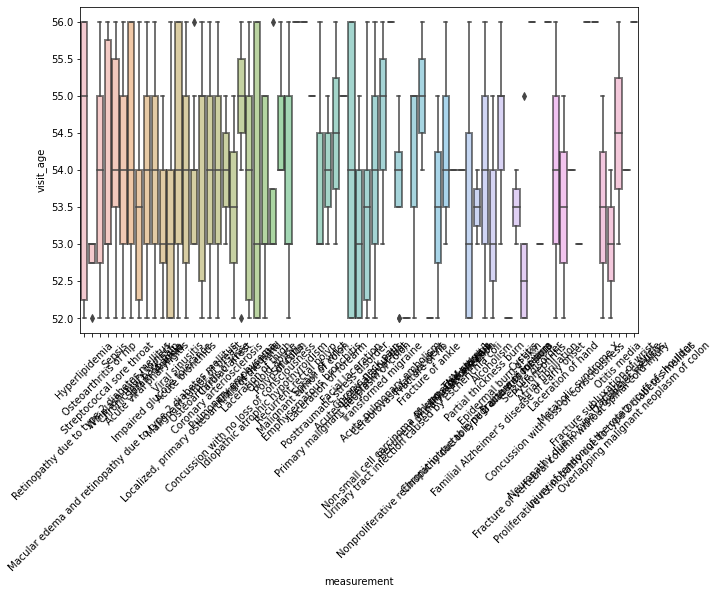

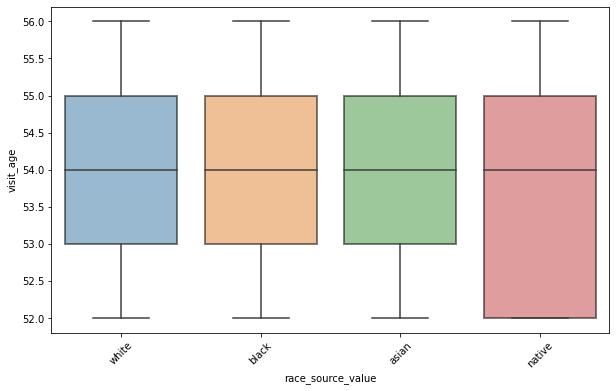

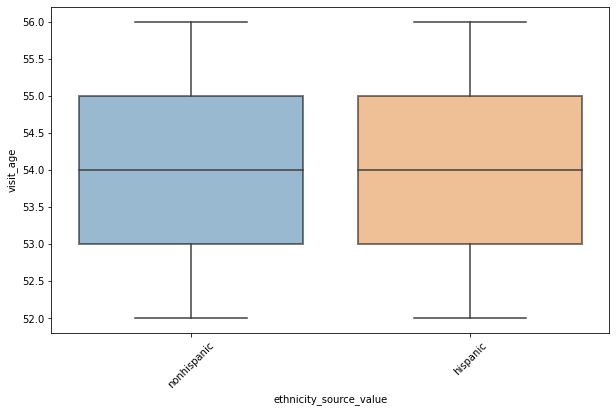

In [40]:
# plot of age across categories (box plots)
for cat in cat_col:
    plt.figure(figsize = (10, 6))
    ax = sns.boxplot(x=cat, y='visit_age', data=df_temp)
    plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
    plt.xticks(rotation=45)

Both of the two gender people have the same medium visit_age:54.
The race in native has the lowest visit_age.


# Short Answer Questions

concept: one patient_id mapps to many concepts

person: one patient_id mapps to one person_id/t

measurement: one patient_id mapps to many measurements

In [47]:
df

,visit_start_datetime,person_id,gender_concept_id,visit_age,race_source_value,ethnicity_source_value,visit_length_hours,hypertension,diabetes,measurement
0,2012-06-28,11,8507,56,white,nonhispanic,0,absence,absence,Hyperlipidemia
1,2012-07-19,11,8507,56,white,nonhispanic,0,absence,absence,NaN
2,2021-01-13,12,8507,52,white,nonhispanic,0,absence,absence,NaN
3,2022-01-19,12,8507,53,white,nonhispanic,0,absence,absence,NaN
4,2010-03-27,16,8532,54,white,nonhispanic,0,absence,absence,NaN
...,...,...,...,...,...,...,...,...,...,...
6023,2021-08-05,11845,8532,52,white,nonhispanic,0,absence,absence,NaN
6024,2022-08-11,11845,8532,53,white,nonhispanic,0,absence,absence,NaN
6025,2022-03-07,11865,8507,52,white,nonhispanic,0,absence,absence,NaN
6026,1986-03-31,11900,8532,55,asian,nonhispanic,0,absence,absence,Osteoarthritis of hip


Question: How to determine which patient have hypertension?

Based on the patient information: gender_concept_id, visit_age, race_source_value, ethnicity_source_value, visit_length_hours, we can eestablish a machine model to predict the status of patient.Firstly, I will do feeature engineering process so that I can take out the useless variables. In this step, I will use gini impurity as my indicator to select and rank all the variables by random forest algorithm. In next step, I will utilize the variables after selection as the input and hypertension as label to establish my prediction model. I believe SVM is a good choice to have a try as it has excellent performance in binary classification problem. After training process, cross-validation will be used to test the performance of my model.

In [53]:
df.to_csv('C:/Users/mw2258/Desktop/dat.csv')